In [1]:
import os
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from mtspec import mtspec
from obspy.core import UTCDateTime
from obspy import read, read_inventory, Stream

In [2]:
from read_arrival import pick_arrival, distances
from plots import plot_traces, plot_windows
from cut_signal import *
from spectra import calc_spectra, differentiate, bin_spectrum
from snr_calc import *
from peakground_calc import *
from writenread import *

In [3]:
class store_traces:
    def __init__(self, original, filtered, filtered_noise):
        self.ori = original
        self.signal = filtered
        self.noise = filtered_noise

class store_fas:
    def __init__(self,storefas):
        signal=[]
        sigfreq=[]
        noise=[]
        noisefreq=[]
        snr=[]
        for i in range(len(storefas)):
            signal.append(storefas[i].Signal)
            sigfreq.append(storefas[i].Signal_freq)
            noise.append(storefas[i].Noise)
            noisefreq.append(storefas[i].Noise_freq)
            snr.append(storefas[i].snr)
        
        self.sig = signal
        self.sfreq = sigfreq
        self.noise = noise
        self.nfreq = noisefreq
        self.snr = snr

            

/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


original continuous record


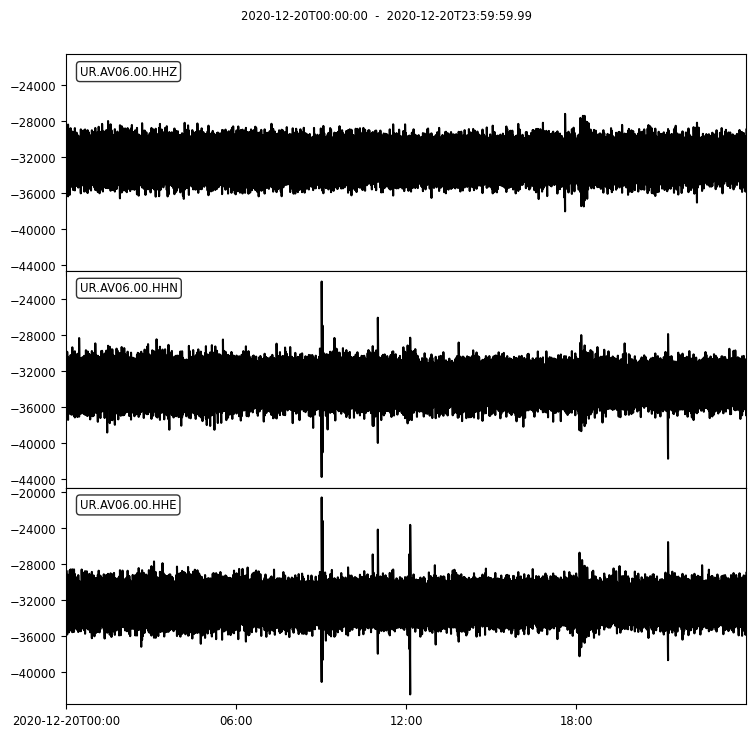

In [4]:
#1. Read catalog.csv
path = os.path.join(os.path.dirname(os.getcwd()),"data_example")
catalog ="Catalog_v2.csv"
df = pd.read_csv(os.path.join(path,catalog))
newid ="UR.AV06_2020-12-20 21:13:22.200"
#Define directory of stations and events inventory
inv = read_inventory(os.path.join(path,'pnr_inventory.xml'),'stationxml')

#2. find 1 event recorded in 1 station from all channels
df['newid'] = df['network']+"."+df['station']+"_"+df["eventid"]
        
#3. find all channel which record one single event in one station
dsameid = df[(df['newid'] == newid)] 
    
#4. take p-time and s-time
ptime= pick_arrival(dsameid, "P")
stime= pick_arrival(dsameid, "S")
repi, rhyp = distances(dsameid)

#5. find the continuous waveform and join as one stream
loc_path = os.path.join(path,"continuous")
if len(dsameid)> 3: 
    dsameid = dsameid.drop_duplicates(subset=['continuous id'], keep='first')
    
st = Stream()
for i in range(len(dsameid)):
    d = dsameid.iloc[i]
    year = d["continuous id"].split(".")[5]
    sta = d['station']
    net = d['network']
    cha = d['channel']
    otime = d['otime']
    recpath = os.path.join(loc_path, year, net, sta)
    recfile = net+ "."+ sta+ ".00."+ cha+ d['eventid']
    s = read (os.path.join(recpath,recfile), format='mseed')
    if len(s) == 1:
        st.append(s[0])
    else:
        print("input should be one single trace!")

print("original continuous record")
st.plot()
#6. trimming signal from 
if dsameid.emag.iloc[0] < 2:
    scale = 1
else:
    scale = 2
    
if rhyp < 150:
    buff_start = 60.0
    buff_end = 3*60.0
else:
    buff_start = 60.0 + scale* ((rhyp - 150 )/ 8.3)
    buff_end = 3*60.0 + scale* ((rhyp - 150 )/ 8.3)

ptime = UTCDateTime(ptime)
stime = UTCDateTime (stime)
otime = UTCDateTime (otime)
start = ptime - buff_start
end = ptime + buff_end


In [18]:
stime

2020-12-20T21:13:59.800000Z

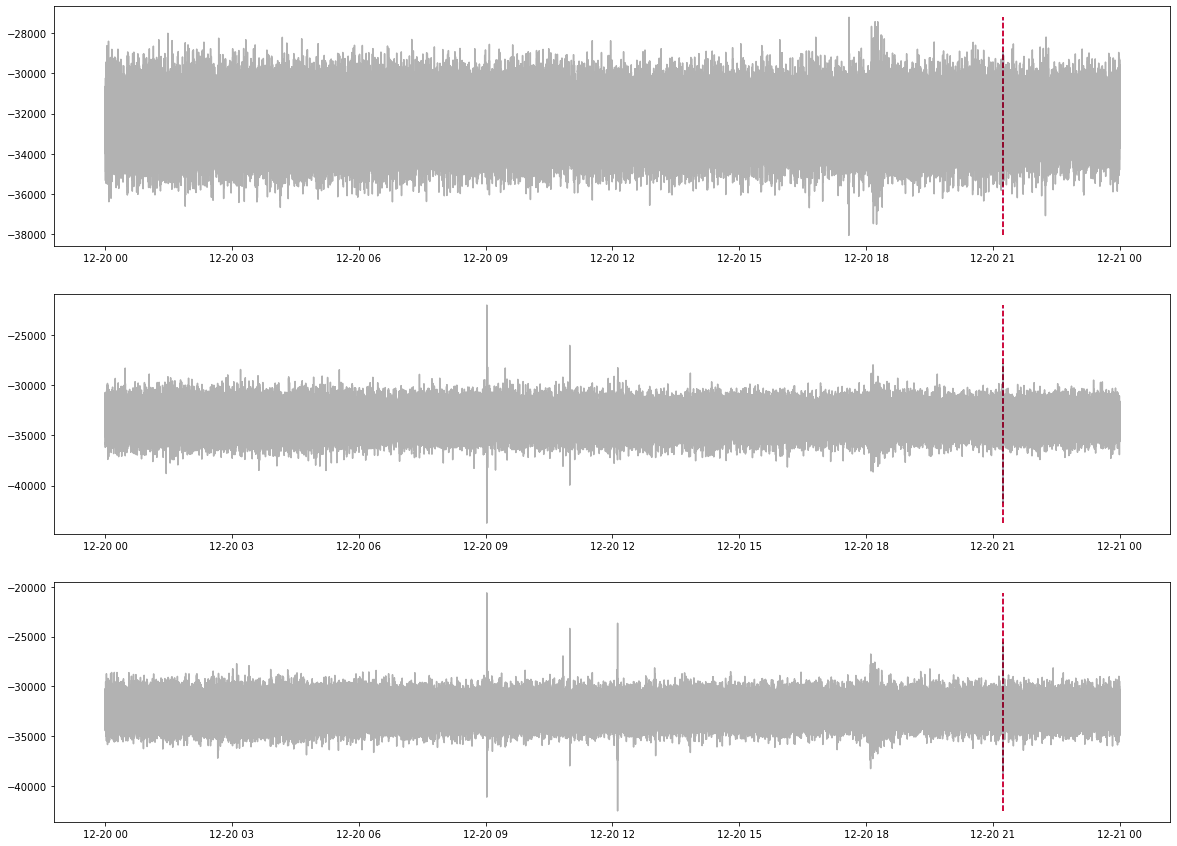

In [16]:
from matplotlib.dates import num2date
fig,ax = plt.subplots(3,1,figsize=(20,15))
for i,tr in enumerate (st):
    time = num2date(np.array([
            (tr.stats.starttime+(tr.stats.delta*(
                i+1))).matplotlib_date for i in range(len(tr.data))]))
    ax[i].plot(time,tr.data, 'k', alpha=0.3)
    ax[i].vlines(ptime, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='b', label='$t_{p}$')
    ax[i].vlines(stime, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='r', label='$t_{s}$')

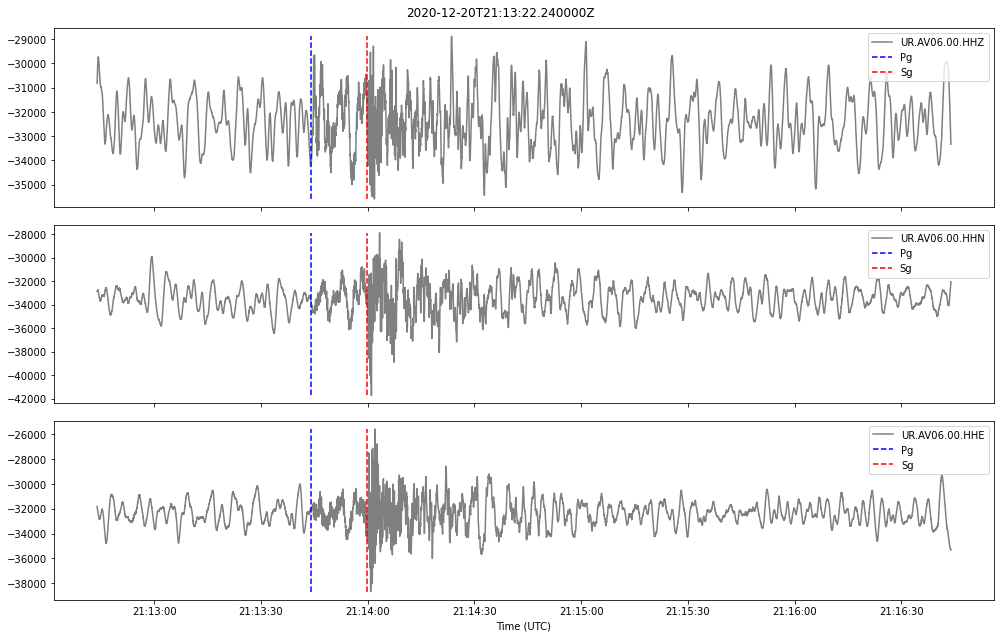

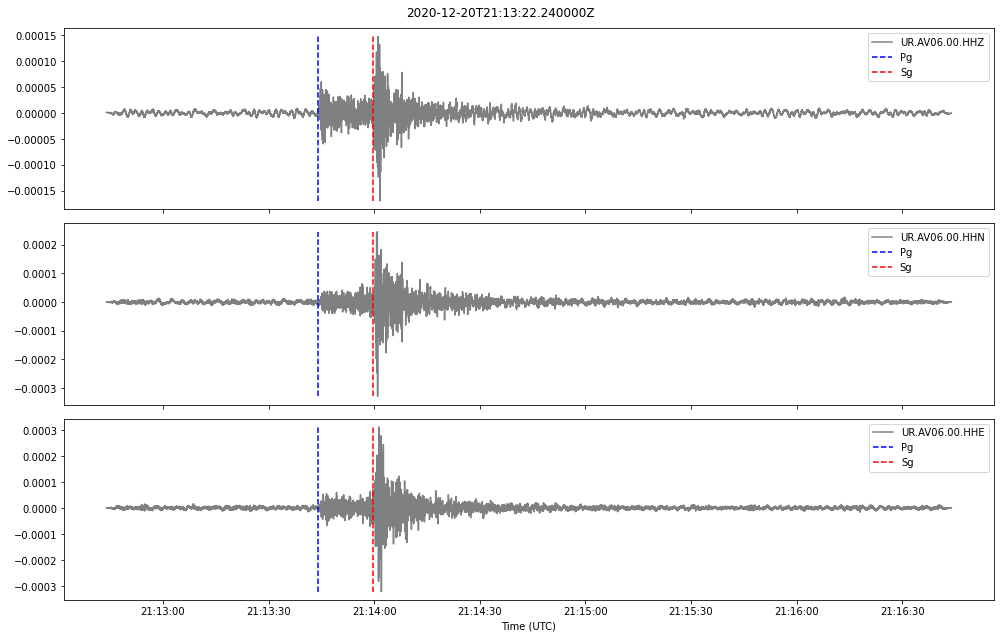

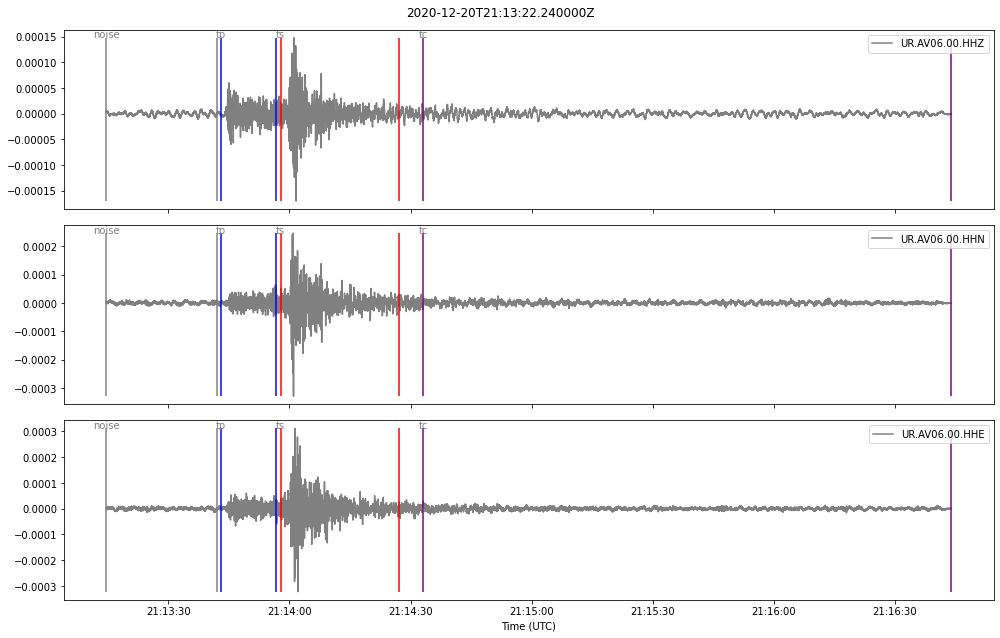

In [5]:
st_ = st.copy()
st_.trim(start, end, pad=True)

#7. update metadata with ptime, stime, distances 
for tr in st_:
    tr.stats['p_time'] = ptime
    tr.stats['s_time'] = stime
    tr.stats['repi_km'] = repi
    tr.stats['rhyp_km'] = rhyp
    tr.stats['otime'] = otime
    tr.stats['wstart'] = start
    tr.stats['wend'] = end

plot_traces(st_, plot_theoreticals=True, plot_windows=False, conv=1)
# plot_traces(st_, plot_theoreticals=True, plot_windows=False, conv=1)
#8. store earthquake recordings 

#10. detrend, pre-filter & instrumetal correction
stc= st_.copy()
out = "ACC"
for tr in stc:
    tr.detrend('demean')
    tr.remove_response(inv, pre_filt=[0.05,0.1,40,45], output= out)
    tr.stats['output'] = out

plot_traces(stc, plot_theoreticals=True, plot_windows=False, conv=1)
#9. signal processing 
    # cut P window, S window, and coda window 
pwave = get_signal(stc, cut_p,bf=1)
swave = get_signal(stc, cut_s,time_after='relative_ps')
cwave = get_signal(stc, cut_c, bf=2, raf=0.8, tafp=2.3 ,percentage= None)
noisewave= get_noise_s(stc, swave, "pre")



plot_windows(stc, conv=1, bft=0, aftt=0,pwave=pwave, swave=swave,
                 cwave=cwave, noise=noisewave, save=None)

In [6]:
#11. PGA, PGV, maxWN calculation
for tr in stc:
    pga, pgv = pgav(tr)
    max_wn = maxwn(tr)
    tr.stats['pga'] = pga
    tr.stats['pgv'] = pgv
    tr.stats['maxWN'] = max_wn 

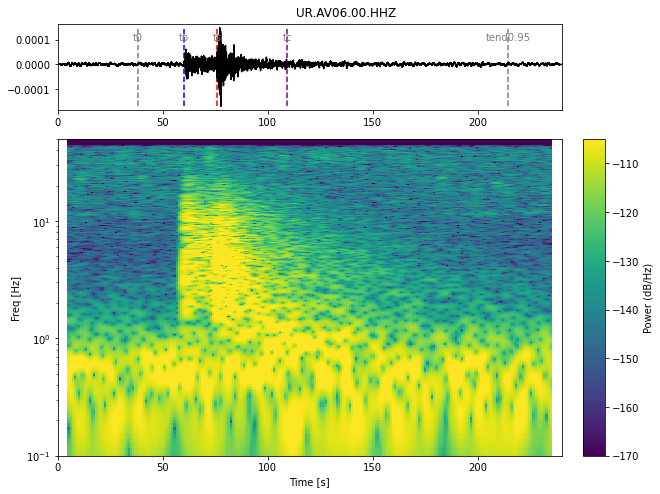

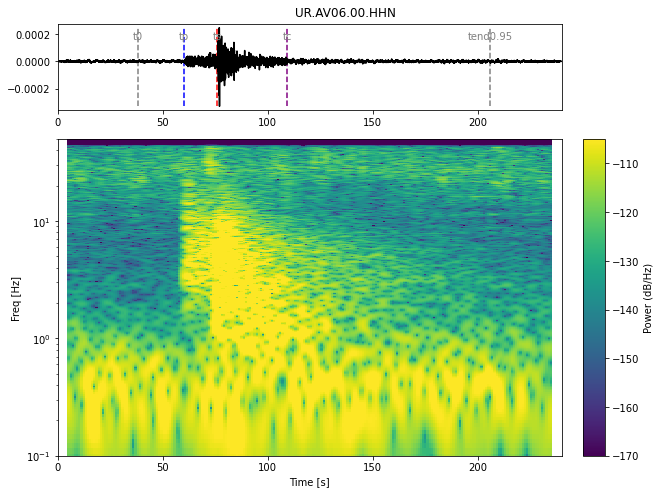

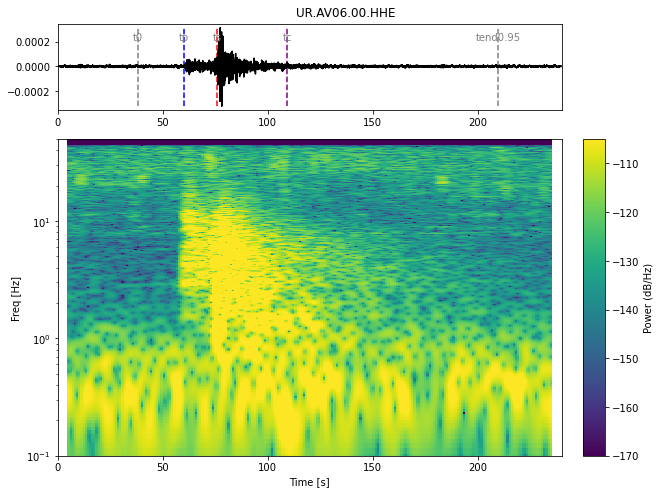

In [8]:
#12. frequency-time plot  
percentage = 0.95
for tr, tc in zip(stc, cwave):
    style = dict(size=10, color='gray')
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_axes([0.1, 0.8, 0.7, 0.15]) #[left bottom width height]
    ax2 = fig.add_axes([0.1, 0.2, 0.7, 0.55], sharex=ax1)
    ax3 = fig.add_axes([0.83, 0.2, 0.03, 0.55])

    
    #make time vector
    sps = int(tr.stats.sampling_rate)
    t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
    ax1.plot(t, tr.copy().data, 'k')
    p = tr.stats['p_time']-tr.stats.starttime
    s = tr.stats['s_time']-tr.stats.starttime
    o = tr.stats['otime']-tr.stats.starttime
    c = tc.stats['wstart']-tr.stats.starttime
    e = calc_tend(tr, percentage,'cav')- tr.stats.starttime
    tr.stats['c_time'] = tc.stats['wstart']
    
    ax1.vlines(o, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='grey', label='$t_{0}$')
    ax1.vlines(p, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='blue', label='$t_{p}$')
    ax1.vlines(s, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='red', label='$t_{s}$')
    ax1.vlines(c, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='purple', label='$t_{c}$')
    ax1.vlines(e, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='grey', label='$t_{0}$')
    
    ax1.text(o, tr.data.max()/1.5, 't0',ha='center', **style)
    ax1.text(p, tr.data.max()/1.5, 'tp',ha='center', **style)
    ax1.text(s, tr.data.max()/1.5,'ts',ha='center', **style)
    ax1.text(c, tr.data.max()/1.5, 'tc',ha='center', **style)
    ax1.text(e, tr.data.max()/1.5, 'tend'+str(percentage),ha='center', **style)

    tr.spectrogram(wlen=.1*sps, per_lap=0.90, dbscale=True,
        log=True, axes=ax2)#, cmap='YlOrRd')
    ax2.set_ylim((0.1,50))
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Freq [Hz]")
    ax2.collections[0].set_clim(vmin=-170, vmax=-105) # Find the quadmesh/pcolormesh created by the spectrogram call, and then change its clims
    mappable = ax2.collections[0]
    cb = plt.colorbar(mappable=mappable, cax=ax3, ticks=np.arange(-210,-100, 10))
    cb.set_label('Power (dB/Hz)') 
    fig.suptitle(tr.id)


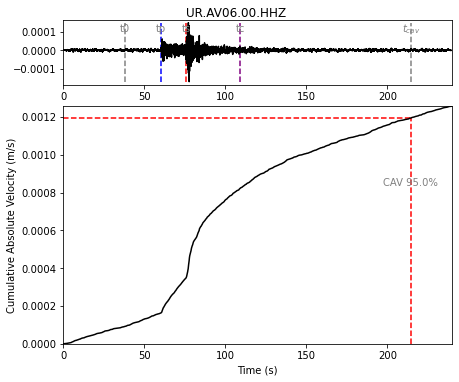

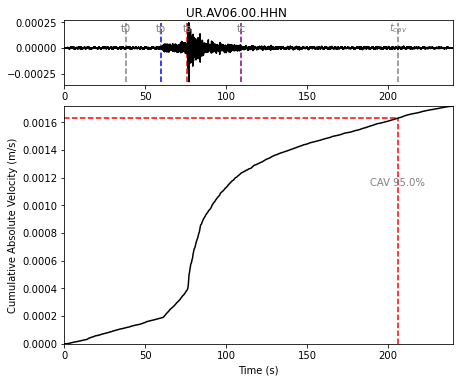

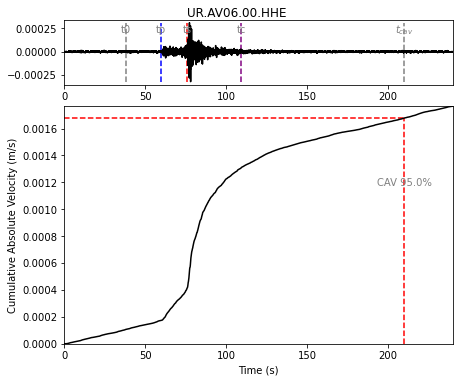

In [11]:
#13. Re-definition of signal window based on cumulative absolute velocity 
cav_endtime=[]
for tr, tc in zip(stc, cwave):
    style = dict(size=10, color='gray')
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_axes([0.1, 0.8, 0.9, 0.15]) #[left bottom width height]
    ax2 = fig.add_axes([0.1, 0.2, 0.9, 0.55], sharex=ax1)

    
    percentage = 0.95
    cav = calc_cav(tr)
#     cav = get_arias(tr)
    cum_cav = cav / max(cav)
    ind = np.where(cum_cav > percentage)[0][0]
    tend = calc_tend(tr, percentage, "cav")
    
    #make time vector
    sps = int(tr.stats.sampling_rate)
    t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
    ax1.plot(t, tr.copy().data, 'k')
    p = tr.stats['p_time']-tr.stats.starttime
    s = tr.stats['s_time']-tr.stats.starttime
    o = tr.stats['otime']-tr.stats.starttime
    c = tc.stats['wstart']-tr.stats.starttime
    e = tend - tr.stats.starttime
    
    ax2.plot(tr.times(),cav,'k')
    ax2.vlines(e,min(cav), cav[ind],
               linestyles='dashed', color='r')
    ax2.hlines(cav[ind],min(tr.times()), e,
              linestyles='dashed', color='r')
    ax2.text(e, max(cav)/1.5, 'CAV '+ str(percentage*100)+'%',ha='center', **style)
    ax2.set_ylabel("Cumulative Absolute Velocity (m/s)")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylim(0, max(cav))
    ax2.set_xlim(0, max(tr.times()))
    
    ax1.vlines(o, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='grey')
    ax1.vlines(p, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='blue')
    ax1.vlines(s, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='red')
    ax1.vlines(c, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='purple')
    ax1.vlines(e, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='grey')
    
    ax1.text(o, tr.data.max()/1.5, 't0',ha='center', **style)
    ax1.text(p, tr.data.max()/1.5, 'tp',ha='center', **style)
    ax1.text(s, tr.data.max()/1.5,'ts',ha='center', **style)
    ax1.text(c, tr.data.max()/1.5, 'tc',ha='center', **style)
    ax1.text(e, tr.data.max()/1.5, "$t_{cav}$",ha='center', **style)

    
    
    # store in metadata and trim signal to tend
    tr.stats['endcav_time'] = tend
    cav_endtime.append(tend)
    fig.suptitle(tr.id)
 

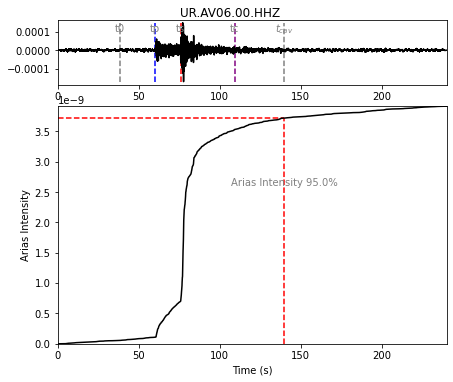

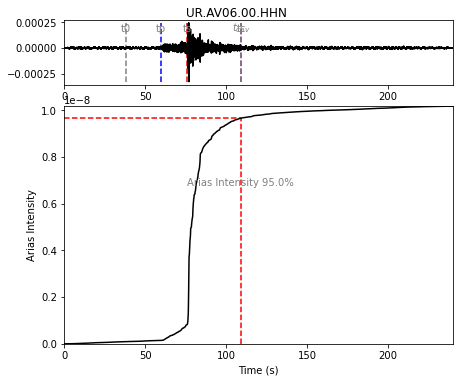

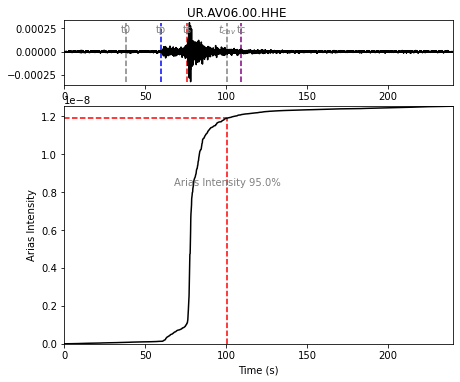

In [12]:
#13. Re-definition of signal window based on cumulative absolute velocity 
cav_endtime=[]
for tr, tc in zip(stc, cwave):
    style = dict(size=10, color='gray')
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_axes([0.1, 0.8, 0.9, 0.15]) #[left bottom width height]
    ax2 = fig.add_axes([0.1, 0.2, 0.9, 0.55], sharex=ax1)

    
    percentage = 0.95
    ai = get_arias(tr)
    cum_ai = ai / max(ai)
    ind = np.where(cum_ai > percentage)[0][0]
    tend = calc_tend(tr, percentage, "ariasintensity")
    
    #make time vector
    sps = int(tr.stats.sampling_rate)
    t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
    ax1.plot(t, tr.copy().data, 'k')
    p = tr.stats['p_time']-tr.stats.starttime
    s = tr.stats['s_time']-tr.stats.starttime
    o = tr.stats['otime']-tr.stats.starttime
    c = tc.stats['wstart']-tr.stats.starttime
    e = tend - tr.stats.starttime
    
    ax2.plot(tr.times(),ai,'k')
    ax2.vlines(e,min(ai), ai[ind],
               linestyles='dashed', color='r')
    ax2.hlines(ai[ind],min(tr.times()), e,
              linestyles='dashed', color='r')
    ax2.text(e, max(ai)/1.5, 'Arias Intensity '+ str(percentage*100)+'%',ha='center', **style)
    ax2.set_ylabel("Arias Intensity")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylim(0, max(ai))
    ax2.set_xlim(0, max(tr.times()))
    
    ax1.vlines(o, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='grey')
    ax1.vlines(p, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='blue')
    ax1.vlines(s, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='red')
    ax1.vlines(c, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='purple')
    ax1.vlines(e, tr.data.min(), tr.data.max(),
        linestyles='dashed', color='grey')
    
    ax1.text(o, tr.data.max()/1.5, 't0',ha='center', **style)
    ax1.text(p, tr.data.max()/1.5, 'tp',ha='center', **style)
    ax1.text(s, tr.data.max()/1.5,'ts',ha='center', **style)
    ax1.text(c, tr.data.max()/1.5, 'tc',ha='center', **style)
    ax1.text(e, tr.data.max()/1.5, "$t_{cav}$",ha='center', **style)

    
    
    # store in metadata and trim signal to tend
    tr.stats['endcav_time'] = tend
    cav_endtime.append(tend)
    fig.suptitle(tr.id)
 

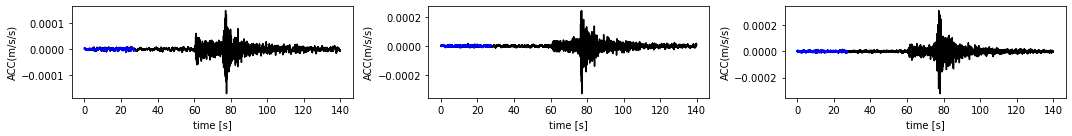

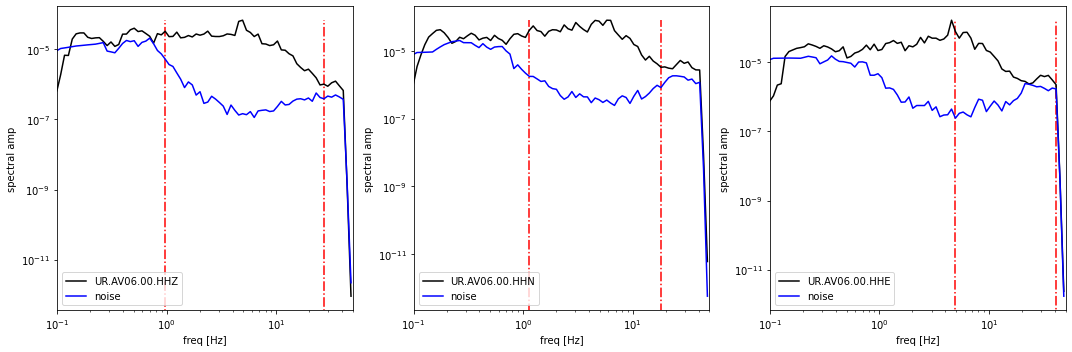

In [13]:
#14. calculate fourier spectra for noise and signal
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

BIN_PARS = {"smin": 0.001, "smax": 200, "bins": 151}
max_endtime = max(cav_endtime)
figx,a = plt.subplots(1,3,figsize=(3*5,2))
fig,ax = plt.subplots(1,3,figsize=(3*5,5))
# stc2 = stc.copy()
# noisewave2= noisewave.copy()
# stc2.integrate()
# noisewave2.integrate()

storefas=[]
for i, (tr, tn) in enumerate(zip(stc, noisewave)):
    tr.trim(tr.stats.starttime, max_endtime)
    t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
    a[i].plot(t,tr.data,'k')
    a[i].plot((np.arange(tn.stats.npts) / tn.stats.sampling_rate),tn.data,'b')
    a[i].set_xlabel('time [s]')
    a[i].set_ylabel(tr.stats.output+"(m/s/s)")
    tr.trim(tr.stats.otime, max_endtime)
    samp, sfreq = calc_spectra(tr)
    namp, nfreq = calc_spectra(tn)
    bnamp, bnfreq = bin_spectrum(namp, nfreq, **BIN_PARS)
    bsamp, bsfreq = bin_spectrum(samp, sfreq, **BIN_PARS)
    bnamp, bnfreq = interp_noise_to_signal(bnamp, bnfreq, bsamp, bsfreq)
    
    ax[i].loglog(bsfreq,bsamp , 'k',label=tr.id)
    ax[i].loglog(bnfreq, bnamp, 'b',label='noise')
    ax[i].set_xlabel('freq [Hz]')
    ax[i].set_ylabel('spectral amp')
    ax[i].set_xlim(0.1,50)
    ax[i].legend()
    
#15. Signal to Noise Ratio
    snr = calc_bsnr(namp, nfreq, samp, sfreq, ROTATE_NOISE=True)
    fas =  pd.DataFrame({"Signal": bsamp, "Signal_freq":bsfreq,
                         "Noise": bnamp, "Noise_freq":bnfreq, "snr": snr})
    storefas.append(fas)
    flow, fup = find_freq_limit(bsfreq,snr,[0.1,45.],3)
    tr.stats['maxWN'] = max_wn 
    tr.stats["flow"] = flow
    tr.stats["fup"] = fup
    ax[i].vlines(flow, 0., bsamp.max(),color='r', linestyle='-.')
    ax[i].vlines(fup, 0., bsamp.max(),color='r',linestyle='-.')

figx.tight_layout()
fig.tight_layout()

In [14]:
#15. Output
# 15.a. store important parameters for every traces in single .csv file
d=[]
for i in range(len(dsameid)):
    df = dsameid.iloc[i]
    df2 = pd.DataFrame({"eventid": df.eventid,
                       "elat":df.elat, "elon": df.elon, "edep": df.edep, "nsta" :df.nsta,
                       "emag" : df.emag, "emagtype": df.emagtype, 
                       "network": df.network, "station" : df.station, "channel" : df.channel,
                       "slat": [df.slat],"slon":[df.slon], "selv": [df.selv]})
    for tr in stc:
        if tr.stats.channel == df.channel:
            de = pd.DataFrame({"starttime": tr.stats.starttime, "origintime" : tr.stats.otime,
                              "arrival_p": tr.stats.p_time, "arrival_s": tr.stats.s_time,
                              "arrival_c": tr.stats.c_time, "endtime_cav": tr.stats.endcav_time,
                              "endtime": tr.stats.endtime, "repi(km)": tr.stats.repi_km,
                              "rhyp(km)": tr.stats.rhyp_km, "pga(m/s/s)": tr.stats.pga,
                              "pgv(m/s)": tr.stats.pgv, "maxWN(m)": tr.stats.maxWN,
                              "flow_snr(Hz)": tr.stats.flow, "fup_snr(Hz)": [tr.stats.fup]
                              })
    d.append(pd.concat([df2, de], axis=1))
result = pd.concat(d)


newpath =os.path.join(os.path.dirname(os.getcwd()),"output")
if not os.path.exists(os.path.join(newpath, "spec")):
    os.makedirs(os.path.join(newpath, "spec"))
    result.to_csv(os.path.join(newpath,"spec",(newid.split(" ")[0]+"T"+newid.split(" ")[1]+".csv")),header=True, index=True)

In [15]:
# 15.b. saving original traces n its metadata, filtered traces n its metadata, noise traces n its metadata, signal-FAS n its freq, noise-FAS n its freq, SNR

store = store_traces(st_, stc, noisewave)
fasstore = store_fas(storefas)

In [16]:
write_methods(os.path.join(newpath,"spec", str(newid)+".sig"), store, method='pickle')
write_methods(os.path.join(newpath,"spec", str(newid)+".spec"), fasstore,method='pickle')
# write_hdf (os.getcwd(),str(newid)+"sig.hdf5", store)
# write_hdf (os.getcwd(),str(newid)+"sig.hdf5", fasstore)

# OPEN AND READ SPECTRA AND SGNAL-NOISE TRACES FROM SAVED FILES

In [17]:

spec =  read_methods(os.path.join(newpath,"spec", str(newid)+".spec"), method='pickle')

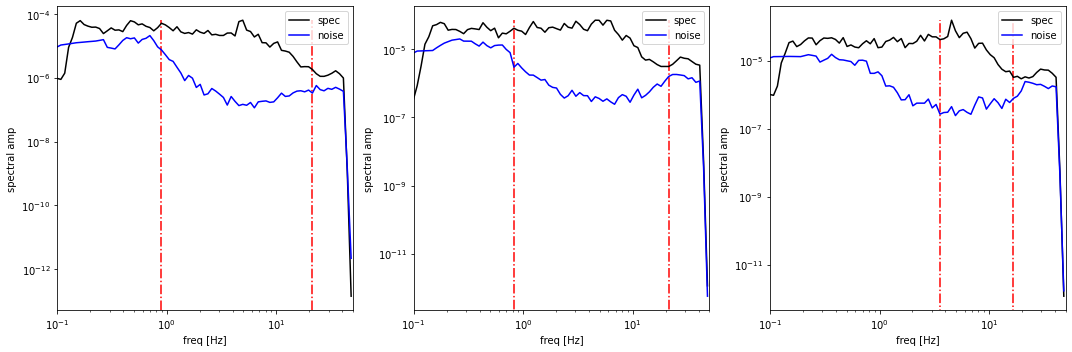

In [18]:

fig,ax = plt.subplots(1,3,figsize=(3*5,5))

for i, (tr, tn) in enumerate(zip(spec.sig, spec.noise)):
    
    ax[i].loglog(spec.sfreq[i], tr , 'k',label="spec")
    ax[i].loglog(spec.nfreq[i], tn, 'b',label='noise')
    ax[i].set_xlabel('freq [Hz]')
    ax[i].set_ylabel('spectral amp')
    ax[i].set_xlim(0.1,50)
    ax[i].legend()
    
#15. Signal to Noise Ratio
    flow = traces.signal[i].stats.flow
    fup = traces.signal[i].stats.fup
    ax[i].vlines(flow, 0., (spec.sig[i]).max(),color='r', linestyle='-.')
    ax[i].vlines(fup, 0., (spec.sig[i]).max(),color='r',linestyle='-.')


fig.tight_layout()

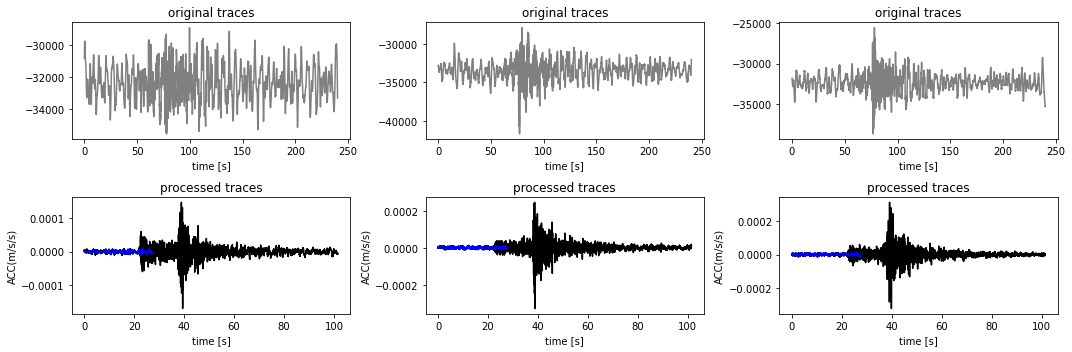

In [24]:
traces = read_methods(os.path.join(newpath,"spec", str(newid)+".sig"), method='pickle')

figx,a = plt.subplots(2,3,figsize=(3*5,5))

for i, (to, tr, tn) in enumerate(zip(traces.ori, traces.signal, traces.noise)):
    t_ = np.arange(to.stats.npts) / to.stats.sampling_rate
    t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
    a[0,i].plot(t_, to.data,'grey')
    a[0,i].set_xlabel('time [s]')
    a[0,i].set_title('original traces')
    a[1,i].plot(t,tr.data,'k')
    a[1,i].plot((np.arange(tn.stats.npts) / tn.stats.sampling_rate),tn.data,'b')
    a[1,i].set_xlabel('time [s]')
    a[1,i].set_ylabel(tr.stats.output+"(m/s/s)")
    a[1,i].set_title('processed traces')
figx.tight_layout()